In [1]:
import matplotlib.pyplot as plt
import numpy as np
from numpy.typing import ArrayLike
import os
import pathlib
from scipy import fftpack
import sys
from typing import Callable

curr_dir = pathlib.Path(os.getcwd())
prj_dir = curr_dir.parent.parent
sys.path.insert(0, str(prj_dir))
from grf_lab.models.kmod import cosmos

data_dir = curr_dir / "data"
figs_dir = curr_dir / "figs/grfs/" # Change this to your specification


for _path in [data_dir, figs_dir]:
    if not _path.exists():
        os.makedirs(_path, exist_ok=True)

## Section 6.2 - Generate a GRF dataset

- Generate a training set by sampling from a prior. The prior should be
uniform in A and B.
- Also generate a separate field that is not part of your training dataset.
The parameters of this field should still be within the prior! This will be
your observed data.

We'll generate the dataset-parameters `parameters` and the measurement-parameters `AB` using the same params as the ones used in the example notebook:

 - Measured parameters: `A=1, b=2.5`
 - Parameter range: $A\in U[0.1, 2],\, B\in U[2, 3]$

In [2]:
# Generate a multi cosmology dataset    
n_sims = 5_000
n_pix = 64
box_dim = 1.

AB = np.array([1., 2.5]) # Fiducial cosmology
lower = np.array([0.1, 2.])
upper = np.array([2., 3.])
param_names = ["A", "B"]

parameters = np.stack(
    [
        np.random.uniform(low=lower[0], high=upper[0], size=n_sims),
        np.random.uniform(low=lower[1], high=upper[1], size=n_sims)
    ], 
    axis=1
)

parameters.shape  # The training set disccused in the notebook

(5000, 2)

Let's visualize the distribution of the generated parameters

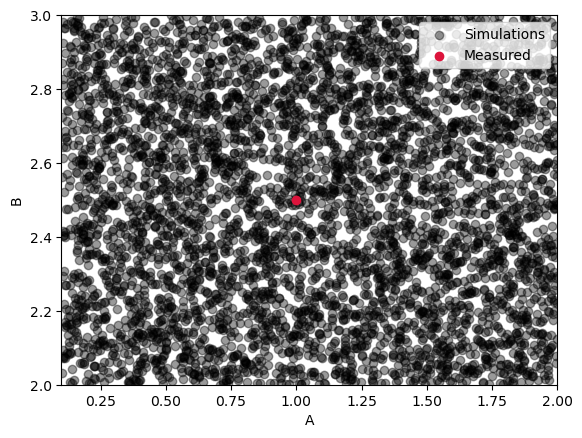

In [3]:
fig = plt.figure()
plt.scatter(*parameters.T, alpha=0.4, c="k", label="Simulations")
plt.scatter(*AB.T, c="crimson", label="Measured")
plt.xlabel(param_names[0])
plt.xlim(lower[0], upper[0])
plt.ylabel(param_names[1])
plt.ylim(lower[1], upper[1])
plt.legend(loc="upper right")
plt.show()

Each of these parameter-sets $(A, B)$ represents a different power spectrun $A\cdot k^{-B}$.

Next we'll simulate a GRF for each parameter pair, and the measurement.
For each such GRF simulation:

 - 2 random fields$\in\mathbb{R}^{64\times64}$ were generated, such that:
   - The field values $\sim Norm[\mu=0, \sigma=1]$.
   - All field values (pixels) are statistically independent.
 - The 2 fields $\text{img}_r\,,\, \text{img}_i\in\mathbb{R}^{64\times64}$ were combined into one: $\text{img}_r + \text{img}_i \cdot i \in \mathbb{C}^{64\times64}$. This field represents the k-space of the GRF.
 - The k-space image is adjusted according to the power spectrum $A\cdot k^{-B}$.
 - An inverse Fourier transform is used to translate the k-space image into x-space.
 - The real values of the resulting image is GRF.

In [4]:
fields = np.zeros((n_sims, n_pix, n_pix))
for i, (A, B) in enumerate(parameters):
    pk_fn: Callable = cosmos.make_power_spectrum(A, B)
    fields[i] = cosmos.make_gaussian_random_field(n_pix, box_dim, pk_fn, random_seed=i)
    print(f"\r{i=} {fields[i].max()=}, {fields[i].min()=}", end="")

# Make a measurement using the true parameters
A, B = AB
pk_fn = cosmos.make_power_spectrum(A, B)
data = cosmos.make_gaussian_random_field(n_pix, box_dim, pk_fn, random_seed=128973874)
data.shape

i=4999 fields[i].max()=2.2247507236092217, fields[i].min()=-2.670344623656953754

(64, 64)

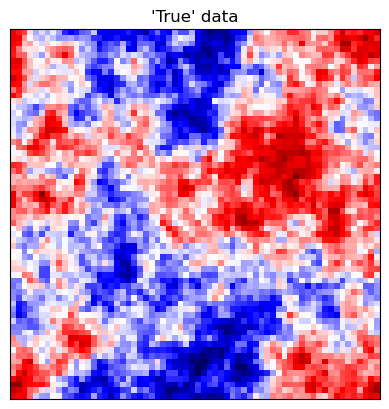

In [5]:
fig = plt.figure()
plt.imshow(data, cmap="seismic")
plt.title(f"'True' data")
plt.xticks([])
plt.yticks([])
plt.show()

We'll save all resulting data for reusability.

In [6]:
np.save(os.path.join(data_dir, f"grfs_{n_pix=}.npy"), fields)
np.save(data_dir / f"grfs_{n_pix=}.npy", fields)
np.save(data_dir / f"data_{n_pix=}.npy", data)
np.save(data_dir / f"grfs_parameters_{n_pix=}.npy", parameters)
np.savez(data_dir / f"data", fields=fields, data=data, parameters=parameters, true_params=AB)

all_data = np.load(data_dir / f"data.npz")
for k, v in all_data.items():
    print(k, v.shape)

fields (5000, 64, 64)
data (64, 64)
parameters (5000, 2)
true_params (2,)


The following plot creates GRFs using the `true power spectrum`, with the initial random noise in k-space as the first 100 simulations.

C:\Users\Kostya\Documents\ai_lab\SBI\grf_lab_fork\grf_lab\models\kmod\cosmos.py:235: RuntimeWarning: invalid value encountered in divide
  outdata /= n_modes


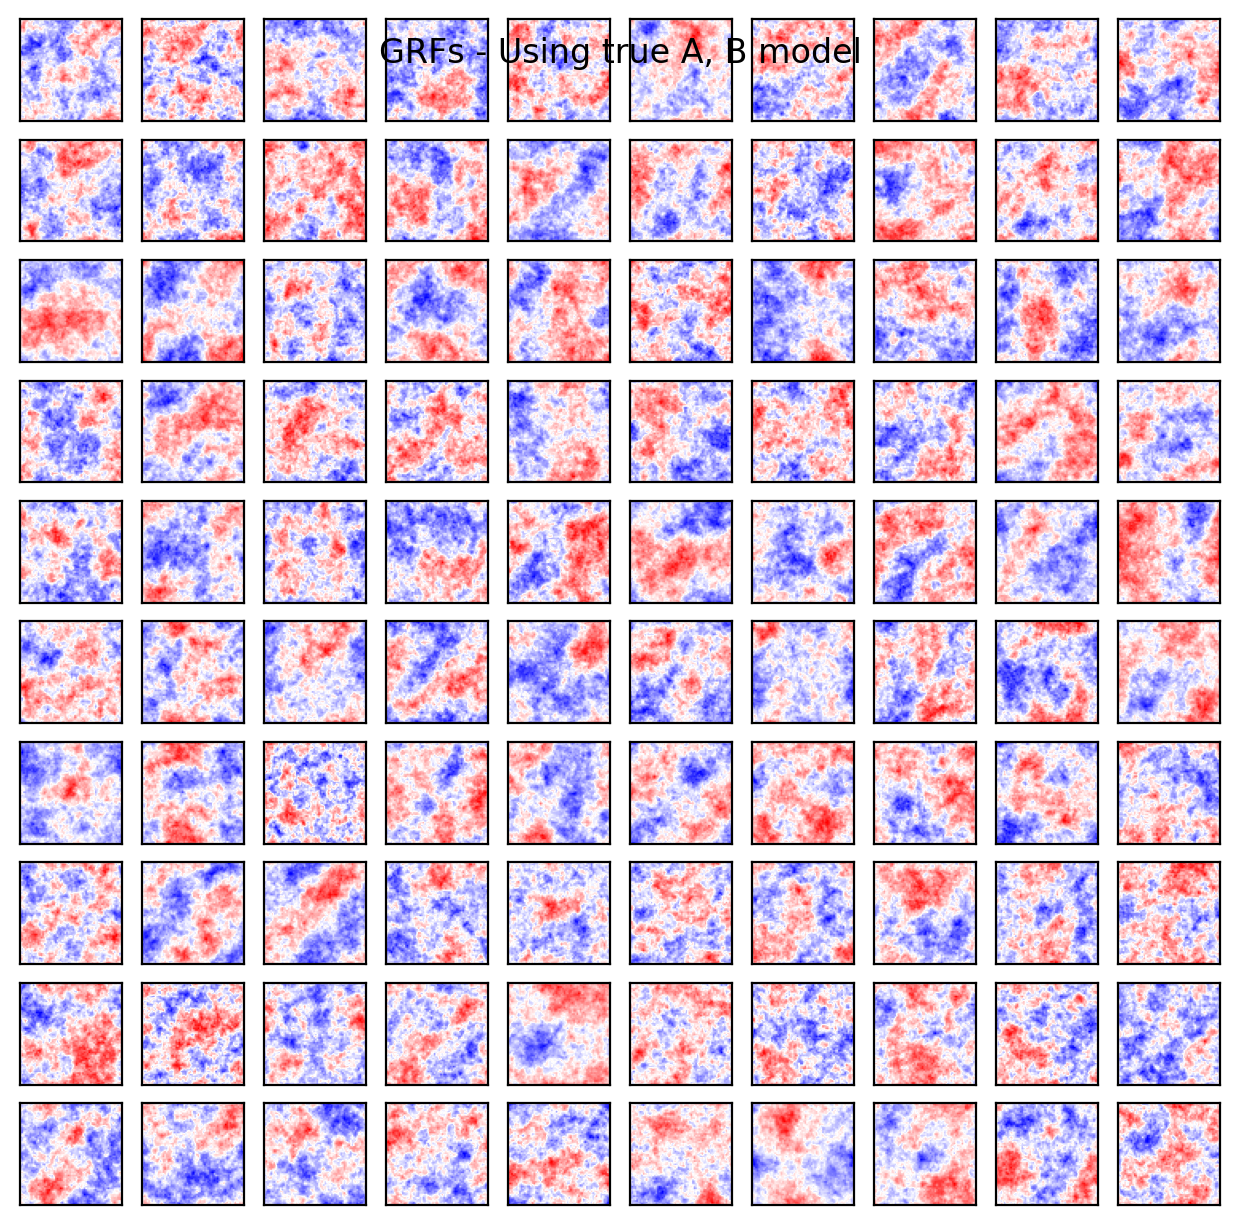

k.shape=(100,), pks.shape=(100, 100), pk.shape=(100,)


In [7]:
n_draws = 100

fig, axd = plt.subplot_mosaic(
    np.asarray([str(n) for n in range(100)]).reshape(10, 10), 
    figsize=(6., 6.),
    dpi=200,
    subplot_kw={"xticks" : [], "yticks" : []},
    gridspec_kw={
        "hspace" : 0.04, "left" : 0.0, "right" : 1.0, "top" : 1., "bottom" : 0.
    }
)

pks = np.zeros((n_draws, 100))
for i in range(n_draws):
    x = cosmos.make_gaussian_random_field(
        n_pix=n_pix,
        box_dim=box_dim,
        power_spectrum=pk_fn,
        random_seed=i
    ) 

    pk, k, modes = cosmos.power_spectrum_1d(x, box_dims=box_dim, kbins=100)
    pks[i] = pk

    axd[str(i)].imshow(x, cmap="bwr")

plt.suptitle("GRFs - Using true A, B model")
plt.savefig(figs_dir / "grfs.png")
plt.show()

print(f"{k.shape=}, {pks.shape=}, {pk.shape=}")

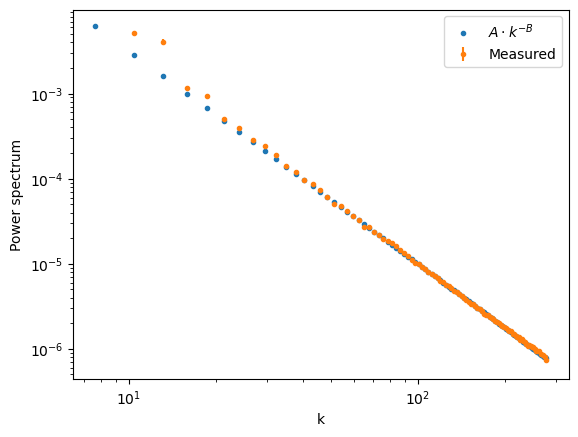

In [8]:
plt.figure()
plt.plot(k, pk_fn(k), marker=".", linestyle="", label="$A\cdot k^{-B}$")
plt.errorbar(k, pks.mean(axis=0), yerr=pks.std(axis=0) / np.sqrt(n_draws), marker=".", linestyle="", label="Measured")
plt.yscale("log")
plt.ylabel("Power spectrum")
plt.xscale("log")
plt.xlabel("k")
plt.legend()
plt.savefig(figs_dir / "Pk_fid.png", bbox_inches="tight")
plt.show()

If we compare it to GRFs using the simulated params:

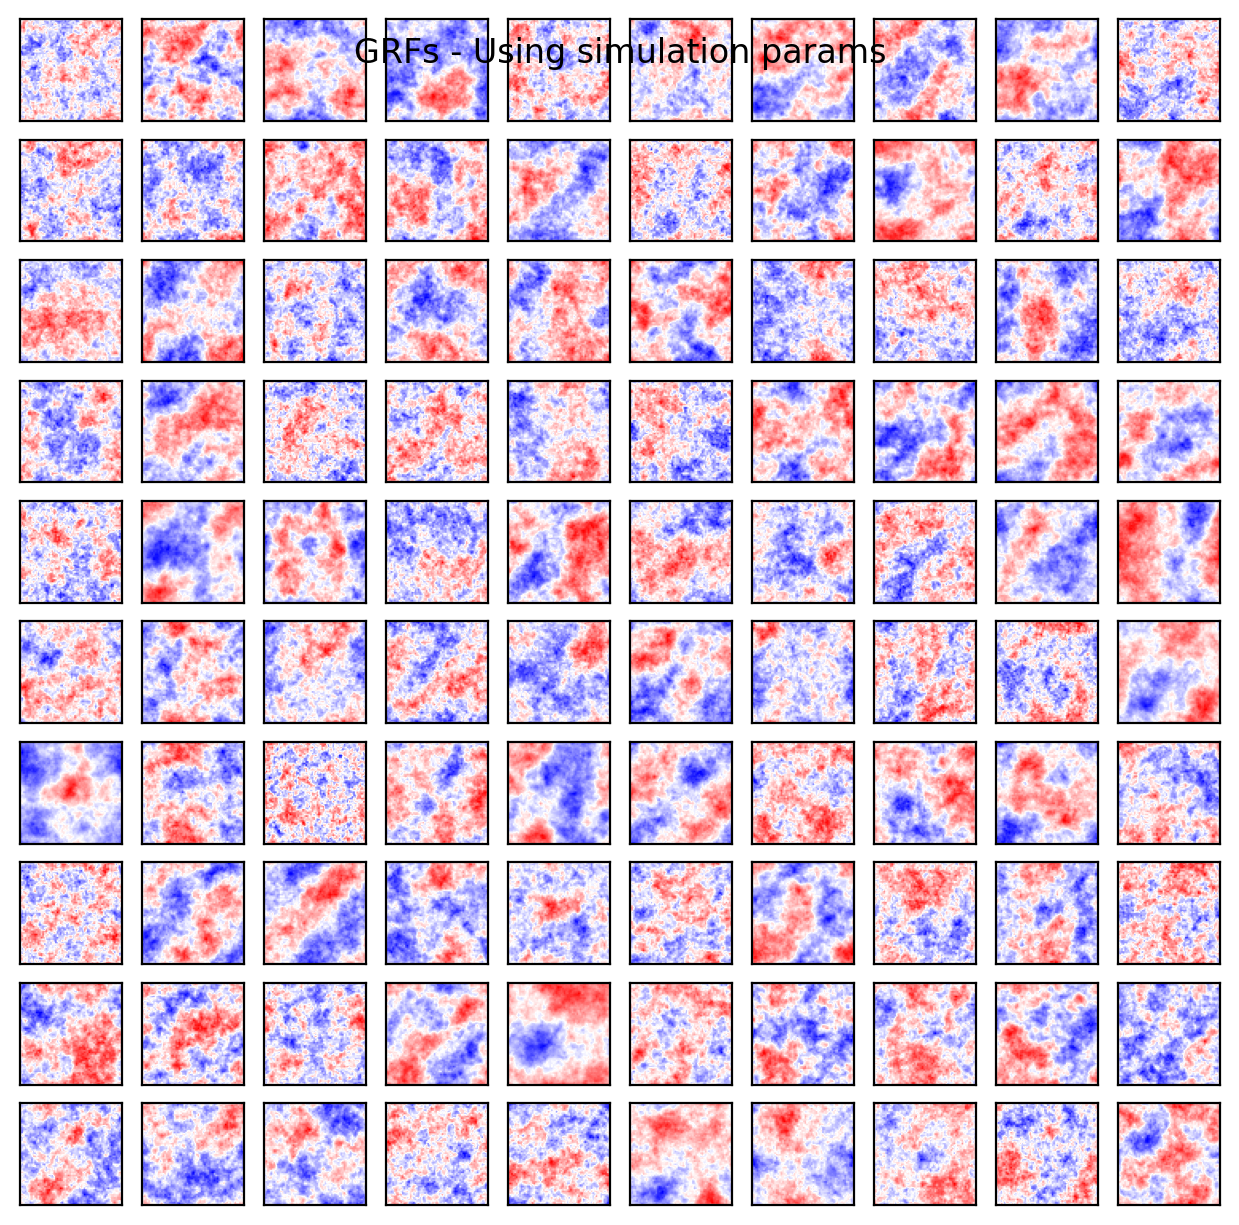

In [9]:
fig, axd = plt.subplot_mosaic(
    np.asarray([str(n) for n in range(100)]).reshape(10, 10), 
    figsize=(6., 6.),
    dpi=200,
    subplot_kw={"xticks" : [], "yticks" : []},
    gridspec_kw={
        "hspace" : 0.04, "left" : 0.0, "right" : 1.0, "top" : 1., "bottom" : 0.
    }
)

pks_multi_cos = np.zeros((n_draws, 100))
for i, (A, B) in enumerate(parameters[:n_draws]):
    pk_fn = cosmos.make_power_spectrum(A, B)

    x = cosmos.make_gaussian_random_field(
        n_pix,
        box_dim=box_dim,
        power_spectrum=pk_fn,
        random_seed=i
    ) 
    # x = fields[i]

    pk, k, modes = cosmos.power_spectrum_1d(x, box_dims=box_dim, kbins=100)
    pks_multi_cos[i] = pk

    axd[str(i)].imshow(x, cmap="bwr")

plt.suptitle("GRFs - Using simulation params")
plt.savefig(figs_dir / "multi_cosmo_grfs.png", bbox_inches="tight")
plt.show()

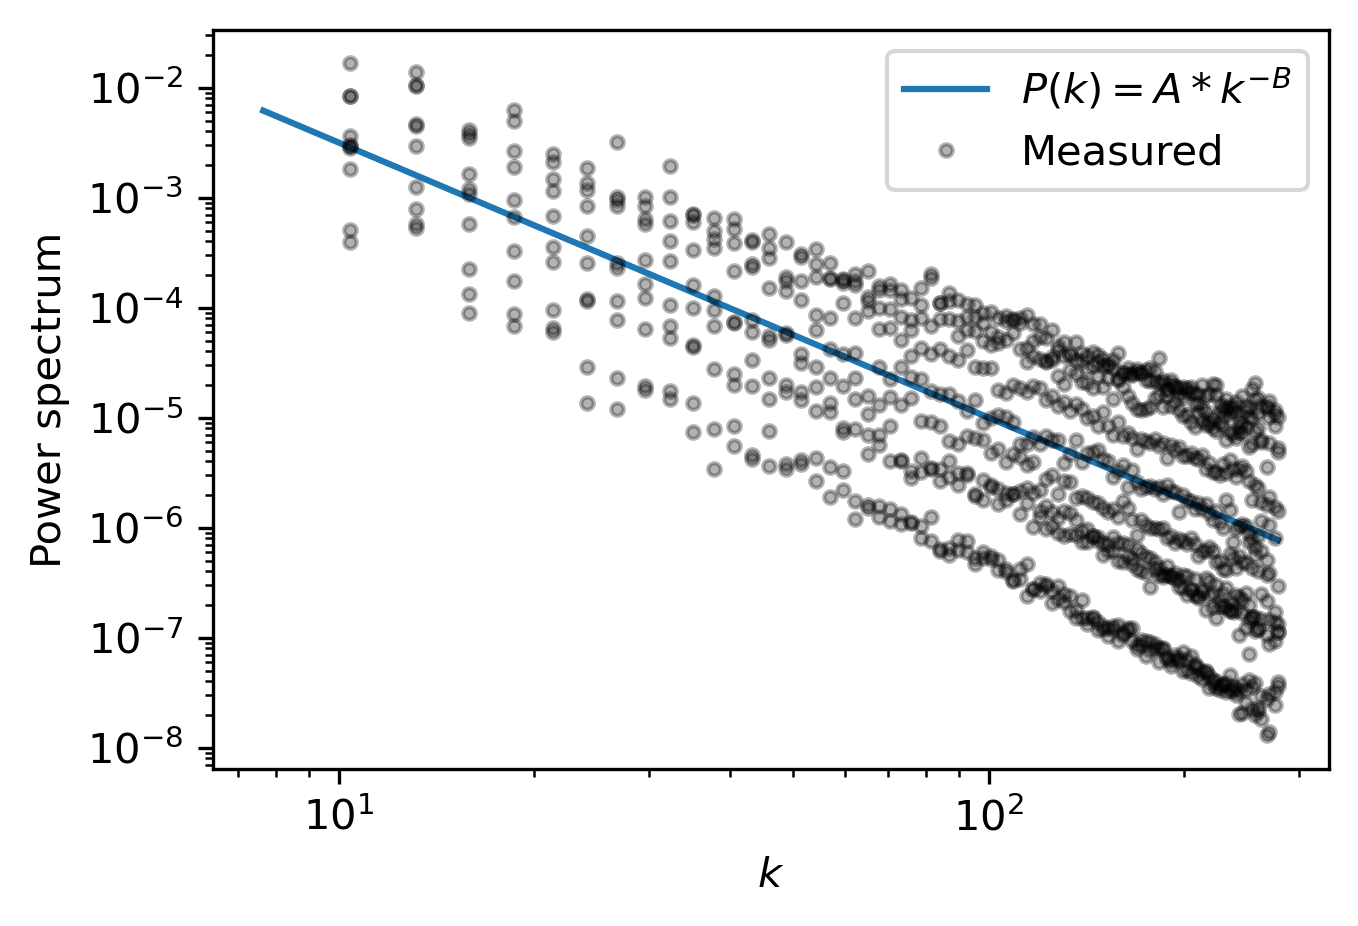

In [10]:
plt.figure(dpi=300, figsize=(4.8, 3.2))
# plt.plot(k, pk_fn(k), label="$P(k)=A * k^{-B}$") 
plt.plot(k, cosmos.make_power_spectrum(*AB)(k), label="$P(k)=A * k^{-B}$") 
for i in range(10):
    plt.plot(
        k, 
        pks_multi_cos[i], 
        marker=".", 
        linestyle="", 
        alpha=0.3,
        color="k", 
        label="Measured" if i == 0 else None
    )
plt.xlabel("$k$")
plt.ylabel("Power spectrum")
plt.yscale("log")
plt.xscale("log")
plt.legend()
plt.savefig(figs_dir / "multi_cosmo_pk.png", bbox_inches="tight")
plt.show()

We can compare the difference between the resulting spectrums directly

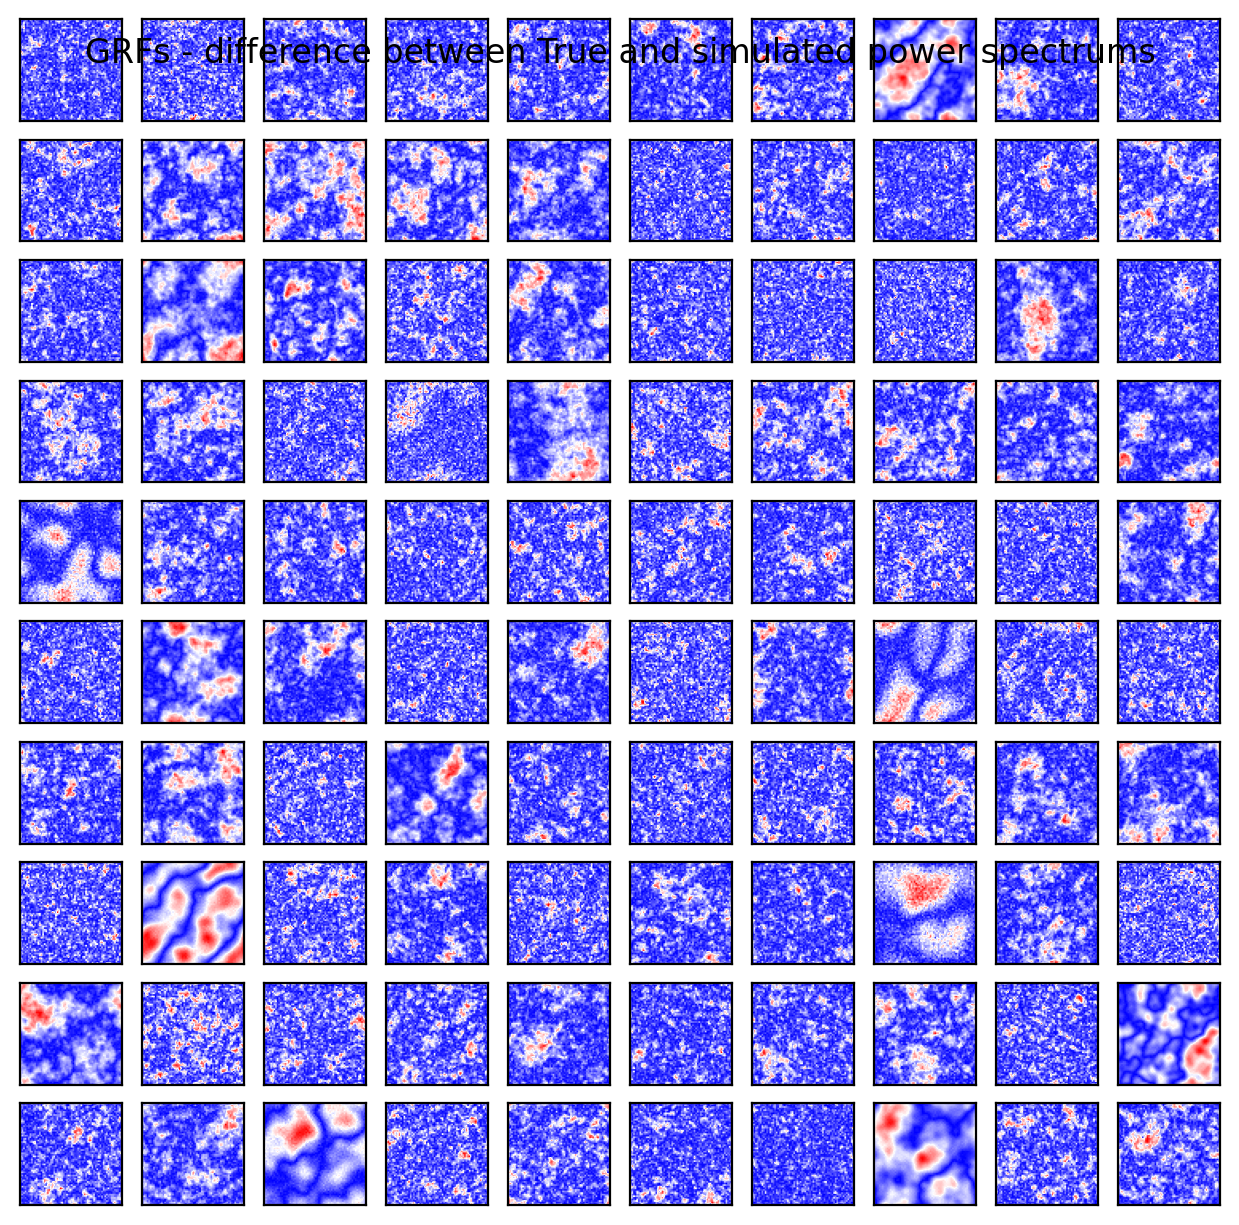

In [11]:
n_draws = 100

fig, axd = plt.subplot_mosaic(
    np.asarray([str(n) for n in range(100)]).reshape(10, 10), 
    figsize=(6., 6.),
    dpi=200,
    subplot_kw={"xticks" : [], "yticks" : []},
    gridspec_kw={
        "hspace" : 0.04, "left" : 0.0, "right" : 1.0, "top" : 1., "bottom" : 0.
    }
)

pk_fn = cosmos.make_power_spectrum(*AB)
for i in range(n_draws):
    x = cosmos.make_gaussian_random_field(
        n_pix=n_pix,
        box_dim=box_dim,
        power_spectrum=pk_fn,
        random_seed=i
    ) - fields[i]
    img = axd[str(i)].imshow(np.abs(x), cmap="bwr")
    # plt.colorbar(img, ax=axd[str(i)], shrink=0.5)  # clutters the image too much

plt.suptitle("GRFs - difference between True and simulated power spectrums")
# plt.savefig(figs_dir / "grfs-comparison.png")
plt.show()

# Sub-question

To compare the SBI approach to the analytic approach we need to calculate
likelihood of a GRF given a sample of parameters π.

 - Fourier transform a GRF realisation to k-space to obtain a grid like
panel c) of Figure 4.

We'll create such a grid for the 1st simulation:

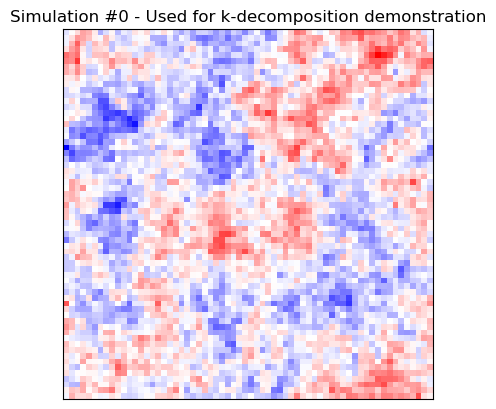

In [12]:
sim_idx = 0

fig = plt.figure()
plt.imshow(fields[sim_idx], cmap="bwr")
plt.xticks([])
plt.yticks([])
plt.title(f"Simulation #{sim_idx} - Used for k-decomposition demonstration")
plt.show()

A few notes regarding the recreation of the graph:

 - Each step here represents all components that have a certain total $|k|$ value, while in the PDF, each step represented one point in k-space.
 - We're not recreating the original image completely in the accumelative section since the image has less cells than the number of unique components.
 - Another error is occuring here due to the Gibbs phenomena, since the frequency filtering is not applied smoothly.
 - In the component representation section [bottom], in each cell the components ewre chosen to have the same weight to better represent the symmetry (i.e. `np.where(mask, 1, 0)` and not `np.where(mask, ft, 0)`).

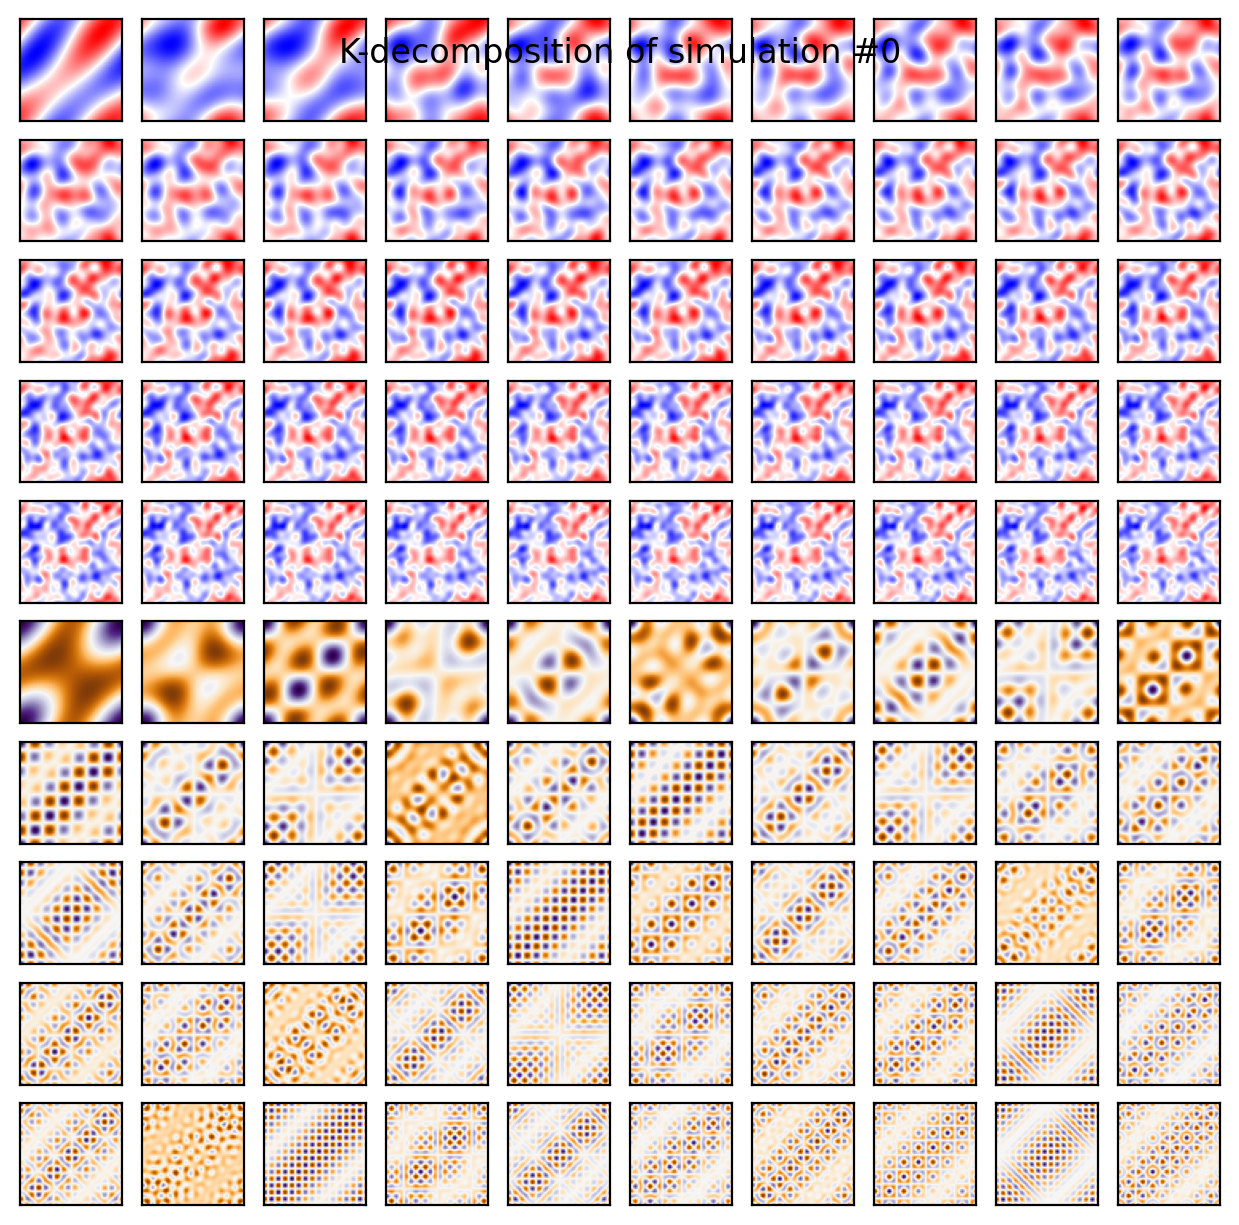

In [13]:
n_draws, sim_idx = 100, 0

fig, axd = plt.subplot_mosaic(
    np.asarray([str(n) for n in range(100)]).reshape(10, 10), 
    figsize=(6., 6.),
    dpi=200,
    subplot_kw={"xticks" : [], "yticks" : []},
    gridspec_kw={
        "hspace" : 0.04, "left" : 0.0, "right" : 1.0, "top" : 1., "bottom" : 0.
    }
)

ft, _, _, k = cosmos.fft_with_k(fields[sim_idx])
mask_acc = np.zeros_like(ft).astype(bool)
cyc_size = n_draws // 2
for i, k_th in enumerate(np.sort(np.unique(k))):
    if i >= cyc_size:
            break
    mask = np.where(k == k_th, True, False)
    mask_acc = mask_acc | mask

    x = cosmos.grf_spectrum_to_x_space(np.where(mask_acc, ft, 0), do_real_only=True)
    axd[str(i)].imshow(x, cmap="bwr")
    x = cosmos.grf_spectrum_to_x_space(np.where(mask, 1, 0), do_real_only=True)
    axd[str(i + cyc_size)].imshow(x, cmap="PuOr")

plt.suptitle(f"K-decomposition of simulation #{sim_idx}")
plt.savefig(figs_dir / "grfs-k-decomposition.png")
plt.show()

To calculate the analytical probability of a GRF assuming a model, we need an algorithm which:

 1. Turns a GRF into a power spectrum.
 2. Finds the power spectrum represented by the parameters.
 3. Calculates the probability of the GRF arrising considering the parameters.
 
    Since the k-space of the GRF is a normal distribution of independent values which follows a poer law, this probability can be found by taking the product of the probabilities of each k-component.

The total probability can be expressed as:

$$
\mathbb{P}(GRF|A, B) = \prod\limits_{i, j=1}^{N}
        \frac
            {1}
            {\sqrt{2\pi\, |A\cdot |\vec{k}_{i, j}|^{-B} |}}
        \large{e^{\frac
            {-{\delta(\vec{k}_{i, j})}^2}
            {2 A \cdot |\vec{k}_{i, j}|^{-B}}
        }}
$$

This functionality was implemented in `cosmos.analytical_grf_probability()`

Using this likelihood function, we can calculate the posterior:

$$
\mathbb{P}(A, B | GRF) = \frac
    {\mathbb{P}(GRF|A, B) \cdot \mathbb{P}(A, B)}
    {\mathbb{P}(GRF)}
$$

but since both $\mathbb{P}(A,B)$ and $\mathbb{P}(GRF)$ are uniform distributions, we can ignore them since they are only used for normalization.
In total, we could say that:

$$
\mathbb{P}(A, B | GRF) \propto \prod\limits_{i, j=1}^{N}
        \frac
            {1}
            {\sqrt{|A\cdot |\vec{k}_{i, j}|^{-B} |}}
        \large{e^{\frac
            {-{\delta(\vec{k}_{i, j})}^2}
            {2 A \cdot |\vec{k}_{i, j}|^{-B}}
        }}
$$

# Sub-question

Create a grid of evenly spaced samples (e.g. using `np.meshgrid[low_A :
high_A : 100j, low_B : high_B : 100j])` and see if you can evaluate the analytic
likelihood and the normalizing flow likelihood over each point in the
grid given a ‘measured’ GRF.

In [14]:
n_a, n_b = 100, 100
a_space, b_space = np.linspace(lower[0], upper[0], n_a), np.linspace(lower[1], upper[1], n_b)
param_grid = np.meshgrid(a_space, b_space)
grid_a, grid_b = param_grid
grid_a.shape, grid_b.shape

((100, 100), (100, 100))

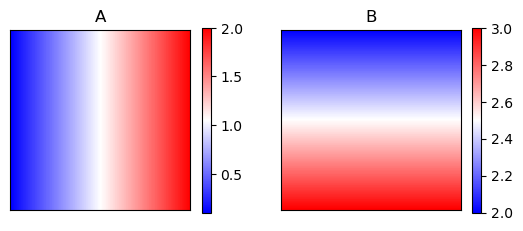

In [15]:
fig, axs = plt.subplots(1, 2)
for ax, prm_grd in zip(axs, param_grid):
    img = ax.imshow(prm_grd, cmap="bwr")
    ax.set_xticks([])
    ax.set_yticks([])
    plt.colorbar(img, ax=ax, shrink=0.5)
axs[0].set_title("A")
axs[1].set_title("B")
plt.show()

The probabilities are:

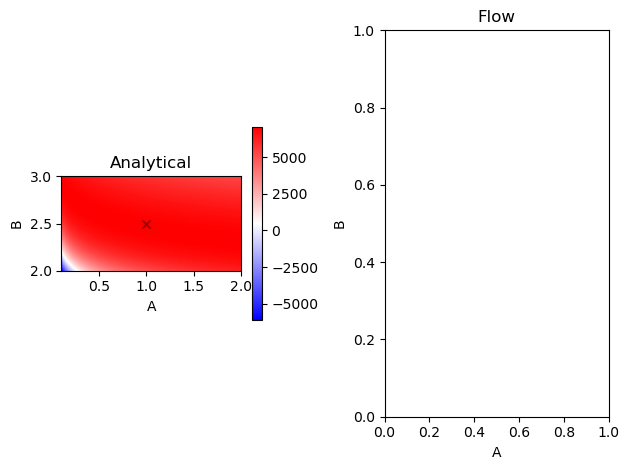

In [19]:
fig, axs = plt.subplots(1, 2)
for ax, prm_grd in zip(axs, param_grid):
    # img = ax.imshow(prm_grd, cmap="bwr")
    # ax.set_xticks([])
    # ax.set_yticks([])
    ax.set_xlabel("A")
    ax.set_ylabel("B")
axs[0].set_title("Analytical")
anal_sol = np.zeros_like(grid_a)
for idx, (aa, bb) in enumerate(zip(*[v.reshape(-1) for v in param_grid])):
    idx_a = idx // n_a
    idx_b = idx % n_a
    anal_sol[idx_a, idx_b] = cosmos.analytical_grf_probability(data, aa, bb, box_dims=box_dim, do_exact_weights=True)
img = axs[0].imshow(anal_sol, cmap="bwr", extent=[lower[0], upper[0], lower[1], upper[1]])
axs[0].scatter(*AB, marker="x", c="k", alpha=0.4, label="True params")
plt.colorbar(img, ax=axs[0], shrink=0.5)

"""
img = axs[1].imshow(np.exp(anal_sol), cmap="bwr", extent=[lower[0], upper[0], lower[1], upper[1]])
axs[1].scatter(*AB, marker="x", c="k", alpha=0.4, label="True params")
plt.colorbar(img, ax=axs[1], shrink=0.5)
"""


axs[1].set_title("Flow")
plt.tight_layout()
plt.show()

In [20]:
anal_sol.min(), anal_sol.max()

(-6123.160285179608, 7067.452377904943)